In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Number of photons on the detector

In [2]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"] = 1
cmd["ATMO_USE_ATMO_BG"] = "yes"
cmd["ATMO_TC"] = "TC_sky_extended.tbl"
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"] = "no"
cmd["FPA_QE"] = "TC_detector_METIS_NQ_no_losses.dat"
metis_filter_id = "Q1"
cmd["INST_FILTER_TC"] = "TC_filter_" + metis_filter_id + ".dat"

In [3]:
opt = sim.OpticalTrain(cmd)

In [4]:
fpa = sim.Detector(cmd, small_fov=False)

In [5]:
## generate a source with N=0 mag
lam, spec = sim.source.flat_spectrum(0, "TC_filter_" + metis_filter_id + ".dat")
#src = sim.Source(lam=lam, spectra=np.array([spec]), 
#                 ref=[0,0], x=[0,0.07], y=[0,0.07])
src = sim.Source(lam=lam, spectra=spec, 
                 ref=[0], x=[0], y=[0])
src_chopped = sim.Source(lam=lam, spectra=spec, 
                 ref=[0], x=[0], y=[1])

#### Directly comparing produced and final number of photons in Simcado

In [6]:
src.spectra

array([[  49089.07070697,  100223.51936006,  100223.51936006, ...,
         100223.51936006,   49089.07070697,       0.        ]])

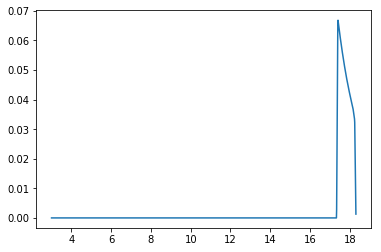

In [7]:
plt.plot(opt.tc_mirror.lam, opt.tc_mirror.val)
# this is the total transmission of METIS in this filter without detector QE

In [8]:
opt._gen_all_tc()
opt.n_ph_mirror
# this is the number of background photons we get in the final produced image
# this number is ~2% lower than the two numbers above multiplied with each other (!?)

12187790.463630298

#### Generate the transmission curves ourselves

In [9]:
TC_ELT=sim.spectral.TransmissionCurve("TC_mirror_total_emissivity.dat")

In [10]:
TC_window=sim.spectral.TransmissionCurve("TC_window_METIS.dat")

In [11]:
TC_dichroic_CFO=sim.spectral.TransmissionCurve("TC_dichroic_CFO.dat")

In [12]:
# TC pupil is 1

In [13]:
TC_CFO_mirrors=sim.spectral.TransmissionCurve("TC_mirror_aluminium.dat")

In [14]:
TC_CFO=TC_CFO_mirrors**19

In [15]:
TC_dichroic_IMG=sim.spectral.TransmissionCurve("TC_dichroic_IMG.dat")

In [16]:
TC_filter=sim.spectral.TransmissionCurve("TC_filter_" + metis_filter_id + ".dat")

In [17]:
#QE_AQUARIUS=sim.spectral.TransmissionCurve("../data/TC_detector_METIS_NQ.dat")
QE_AQUARIUS=sim.spectral.TransmissionCurve("TC_detector_METIS_NQ_no_losses.dat")

In [18]:
TC_total = TC_ELT * TC_window * TC_dichroic_CFO * TC_CFO *\
           TC_dichroic_IMG * TC_filter * QE_AQUARIUS

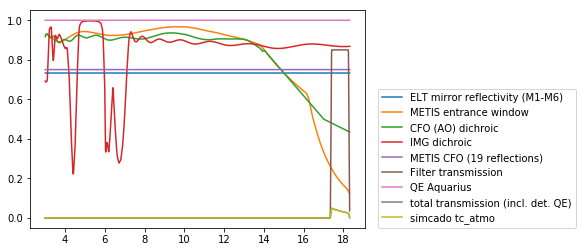

In [19]:
plt.plot(opt.tc_mirror.lam, TC_ELT, label="ELT mirror reflectivity (M1-M6)")
plt.plot(opt.tc_mirror.lam, TC_window, label="METIS entrance window")
plt.plot(opt.tc_mirror.lam, TC_dichroic_CFO, label="CFO (AO) dichroic")
plt.plot(opt.tc_mirror.lam, TC_dichroic_IMG, label="IMG dichroic")
plt.plot(opt.tc_mirror.lam, TC_CFO, label="METIS CFO (19 reflections)")
plt.plot(opt.tc_mirror.lam, TC_filter, label="Filter transmission")
plt.plot(opt.tc_mirror.lam, QE_AQUARIUS, label="QE Aquarius")
plt.plot(opt.tc_mirror.lam, TC_total, label="total transmission (incl. det. QE)")
#plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="simcado tc_mirror")
plt.plot(opt.tc_mirror.lam, opt.tc_atmo, label="simcado tc_atmo")
plt.legend(loc=(1.04, 0))
plt.savefig("METIS_transmission_curves.pdf", bbox_inches='tight')

(17, 19)

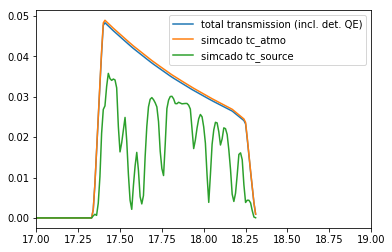

In [33]:
plt.plot(opt.tc_atmo.lam,TC_total,label="total transmission (incl. det. QE)")
plt.plot(opt.tc_atmo.lam,opt.tc_atmo,label="simcado tc_atmo")
plt.plot(opt.tc_source.lam, opt.tc_source, label="simcado tc_source")
plt.legend(loc='best')
plt.xlim([17,19])

#### Compute number of background photons in SimCADO simulated image

In [21]:
src.apply_optical_train(opt, fpa)

Generating image for chip 1


In [22]:
cmd.atmo

{'ATMO_AIRMASS': 1.0,
 'ATMO_BG_MAGNITUDE': None,
 'ATMO_EC': '../data/EC_sky_extended_proper.tbl',
 'ATMO_PRESSURE': 750.0,
 'ATMO_PWV': 2.5,
 'ATMO_REL_HUMIDITY': 60.0,
 'ATMO_TC': '../data/TC_sky_extended.tbl',
 'ATMO_TEMPERATURE': 0.0,
 'ATMO_USE_ATMO_BG': 'yes'}

In [23]:
fpa.read_out()

Reading out chip 1 using superfast
1.27800130701e+13 12187790.4636 16187026.175 12187790.4636
1.278e+13 1.2171e+07 1.61876e+07 1.21878e+07


In [24]:
src.apply_optical_train(opt, fpa)
exptime=1
photonflux = fpa.chips[0].array.T
clean_image = photonflux * exptime ## noise free image before applying Poisson noise

hdu = fpa.read_out(OBS_EXPTIME=1)
src_chopped.apply_optical_train(opt,fpa)
hdu_chopped = fpa.read_out(OBS_EXPTIME=1)

Generating image for chip 1
Reading out chip 1 using superfast
1.27800130701e+13 12187790.4636 16187026.175 12187790.4636
1.278e+13 1.21715e+07 1.61873e+07 1.21878e+07
Generating image for chip 1
Reading out chip 1 using superfast
1.27800130701e+13 12187790.4636 16187026.175 12187790.4636
1.278e+13 1.217e+07 1.61871e+07 1.21878e+07


In [25]:
opt._gen_thermal_emission()[1].photons_in_range()

266293846.17999956

In [26]:
opt._gen_all_tc()
opt.n_ph_mirror

12187790.463630298

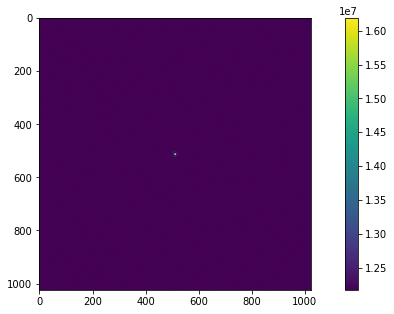

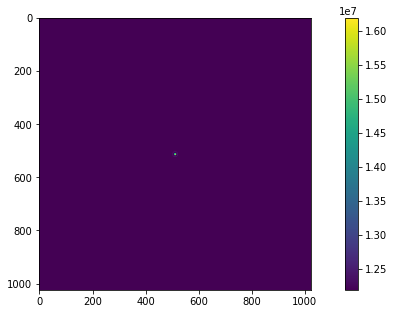

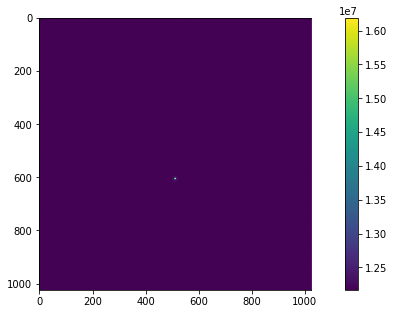

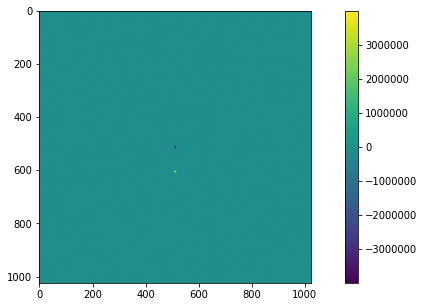

In [28]:
##
## chop A frame
plt.figure(figsize=(12,5))
plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()
##
## chop A frame without noise
plt.figure(figsize=(12,5))
plt.imshow(clean_image, interpolation="none")
plt.colorbar()
##
## chop B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data, interpolation="none")
plt.colorbar()
##
## chop difference A-B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data-hdu[0].data, interpolation="none")
plt.colorbar()

In [29]:
np.std(clean_image[200:400,200:400])

3.3514386122546336

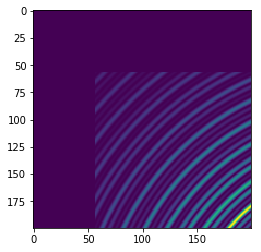

In [30]:
plt.imshow(clean_image[200:400,200:400])

In [31]:
np.std(hdu[0].data[200:400,200:400])

3482.3172602924333

In [43]:
bgphotons_per_pix=np.median(hdu[0].data)
bgphotons_per_pix*=17 ## takes into account bg photons from entrance window, not included in the simulation so far
print("The number of bg counts per second per pix is {0:.2E}".format(bgphotons_per_pix))
## Note that this is identical with bg photons if detector QE is 1 (as in TC_detector_METIS_NQ_no_losses.dat)
## Note also that this is the reason why the Q band is not yet officially supported. We need to create these photons 
##    before reading out the detector to include their shot noise. This is not yet possible in simmetis.

The number of bg counts per second per pix is 2.07E+08


## ELFN

In [40]:
# from Roy; works on chop-difference frame (?)
from  scipy.interpolate import interp1d
def ELFN_penalty(photonflux):
    x=[0, 2e8, 8e8,10e8,25e8] # [ph/s/pix]
    y=[1,1.37,3.38,3.64,4.65] # ELFN noise penalty factor
    penalty_interp=interp1d(x,y)
    penalty=penalty_interp(photonflux)[()]
    return(penalty)

In [41]:
noise = hdu[0].data - clean_image
elfn_image = clean_image + ELFN_penalty(photonflux)*noise
print(np.median(elfn_image[200:400,200:400]))
print(np.std(elfn_image[200:400,200:400]))

12187731.6839
3560.83483632


## Source photons

In [42]:
source_bgsubtracted = np.sum(clean_image-np.median(clean_image))
print("Bg-subtracted source photons (per s): {0:.2E}".format(source_bgsubtracted))

Bg-subtracted source photons (per s): 1.88E+08
